# Core Imports and Setup

In [1]:
import os
from pathlib import Path

import numpy as np

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)

from openff import toolkit, evaluator

from openff.units import unit

from matplotlib import pyplot

import matplotlib.pyplot as plt

from scipy.stats import linregress

# 0) Registering Custom ThermoML Properties

In [2]:
from openff.evaluator import properties
from openff.evaluator.datasets.thermoml import thermoml_property
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase

@thermoml_property("Osmotic coefficient", supported_phases=PropertyPhase.Liquid)
class OsmoticCoefficient(PhysicalProperty):
    """A class representation of a osmotic coeff property"""

    @classmethod
    def default_unit(cls):
        return unit.dimensionless
    
...

custom_thermoml_props = [
    OsmoticCoefficient,
]

for custom_prop_cls in custom_thermoml_props:    
    setattr(properties, custom_prop_cls.__name__, custom_prop_cls)

# 1) - Loading ThermoML Data Sets

## Extracting data from ThermoML

In [3]:
from openff.evaluator.datasets import PhysicalProperty, PropertyPhase, PhysicalPropertyDataSet
from openff.evaluator.datasets.thermoml import thermoml_property, ThermoMLDataSet

data_set_initial = PhysicalPropertyDataSet.from_json("training-properties-with-water.json")
data_set_initial.to_pandas()

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Density Value (g / ml),Density Uncertainty (g / ml),EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Source
0,6385,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.24520,None,O,Solvent,0.75480,None,0.903811,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
1,6386,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.50500,None,O,Solvent,0.49500,None,0.858158,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
2,6387,298.15,101.0,Liquid,2,CN1CCCCC1,Solvent,0.79070,None,O,Solvent,0.20930,None,0.826047,NaN,NaN,NaN,10.1016/j.fluid.2010.05.001
3,6388,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.26433,None,O,Solvent,0.73567,None,0.959000,NaN,NaN,NaN,10.1021/acs.jced.6b00888
4,6389,298.15,101.3,Liquid,2,CN(C)CCO,Solvent,0.50770,None,O,Solvent,0.49230,None,0.923722,NaN,NaN,NaN,10.1016/j.jct.2004.11.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,7294,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.49110,None,O,Solvent,0.50890,None,NaN,NaN,-3.131,NaN,10.1016/j.jct.2015.06.006
119,7295,298.15,101.0,Liquid,2,C1COCCN1,Solvent,0.71490,None,O,Solvent,0.28510,None,NaN,NaN,-1.753,NaN,10.1016/j.jct.2015.06.006
120,7344,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.30050,None,O,Solvent,0.69950,None,NaN,NaN,-6.588,NaN,10.1016/j.jct.2015.04.030
121,7345,303.15,100.0,Liquid,2,NCCCNCCCN,Solvent,0.49980,None,O,Solvent,0.50020,None,NaN,NaN,-5.544,NaN,10.1016/j.jct.2015.04.030


In [4]:
print(len(data_set_initial))
print(data_set_initial.property_types)
print(data_set_initial.substances)

123
{'Density', 'EnthalpyOfMixing'}
{<Substance CN1CCNCC1{solv}{x=0.706500}|O{solv}{x=0.293500}>, <Substance CNCCO{solv}{x=0.504100}|O{solv}{x=0.495900}>, <Substance CN(CCO)CCO{solv}{x=0.494100}|O{solv}{x=0.505900}>, <Substance OCCOCCO{solv}{x=0.301000}|O{solv}{x=0.699000}>, <Substance CN(C)CCCO{solv}{x=0.800100}|O{solv}{x=0.199900}>, <Substance NCCCO{solv}{x=0.489642}|O{solv}{x=0.510358}>, <Substance OCCN(CCO)CCO{solv}{x=0.710000}|O{solv}{x=0.290000}>, <Substance CN(C)CCO{solv}{x=0.536500}|O{solv}{x=0.463500}>, <Substance CC(C)O{solv}{x=0.504800}|O{solv}{x=0.495200}>, <Substance Cc1ccncc1{solv}{x=0.750000}|O{solv}{x=0.250000}>, <Substance CN(C)CCO{solv}{x=0.507700}|O{solv}{x=0.492300}>, <Substance NCCNCCO{solv}{x=0.770000}|O{solv}{x=0.230000}>, <Substance Cc1ccncc1{solv}{x=0.225000}|O{solv}{x=0.775000}>, <Substance CN(C)CCO{solv}{x=0.205200}|O{solv}{x=0.794800}>, <Substance C1CCNCC1{solv}{x=0.500000}|O{solv}{x=0.500000}>, <Substance CN1CCNCC1{solv}{x=0.209100}|O{solv}{x=0.790900}>, <S

## Filtering data set

In [5]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog
from openff.evaluator.substances import Component, Substance

In [6]:
def get_func_smiles(initial_data_set):
    subs=list(set(initial_data_set.substances))
    smiles_list=[]

    for i in subs:
        comps=[]
        comps.append(i.components[0].smiles)
        comps.append(i.components[1].smiles)
        for o in comps:
            comps.remove('O')
            [smiles_list.append(y) for y in comps]


    mols_list=[]

    for s in smiles_list:
        m=Chem.MolFromSmiles(s)
        mols_list.append(m)

 
    alcohols=[]
    amines=[]
    both=[]
    other=[]
    
    fc = FilterCatalog.GetFunctionalGroupHierarchy()
    for i in range(len(mols_list)):
        whtv=mols_list[i]
        if not fc.GetMatches(whtv):
            other.append(i)
        else:
            for match in fc.GetMatches(whtv):
                ffg=match.GetDescription()
                # print(i,ffg)
                if ffg == 'Amine':
                    amines.append(i)
                elif ffg == 'Alcohol':
                    alcohols.append(i)
                if i in amines and i in alcohols:
                    both.append(i)
                    amines.remove(i)
                    alcohols.remove(i)
    

    def get_smiles(func_type):
        smiles=[]

        for x in func_type:
            comp0=subs[x].components[0].smiles
            comp1=subs[x].components[1].smiles
            if comp0 != 'O':
                smiles.append(comp0)
            if comp1 != 'O':
                smiles.append(comp1)
            # smiles.append(comp0) 
            # smiles.append(comp1)
        smiles.append('O')
        return smiles

    smiles_results={}

    smiles_results['alcohols']=get_smiles(alcohols)
    smiles_results['amines']=get_smiles(amines)
    smiles_results['both']=get_smiles(both)
    smiles_results['other']=get_smiles(other)

    return smiles_results

    

In [7]:
# et=mols_list[1]

# if match in fc.GetMatches(et):
#     for match in fc.GetMatches(et):
#         xyz=match.GetDescription()
#         print(xyz)
# else:
#     print("other")

In [8]:
smiles_results=get_func_smiles(data_set_initial)

In [9]:
from openff.evaluator.datasets.curation.components.filtering import FilterByPropertyTypes, FilterByPropertyTypesSchema
from openff.evaluator.datasets.curation.components.filtering import FilterBySmiles, FilterBySmilesSchema

data_set_hmix_dens= FilterByPropertyTypes.apply(
    data_set_initial, FilterByPropertyTypesSchema(property_types=["EnthalpyOfMixing","Density"]))

print(len(data_set_hmix_dens))

data_set_alcohols= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['alcohols']))

print(len(data_set_alcohols))

data_set_amines= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['amines']))

print(len(data_set_amines))

data_set_both= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['both']))

print(len(data_set_both))

data_set_other= FilterBySmiles.apply(
    data_set_hmix_dens, FilterBySmilesSchema(smiles_to_include=smiles_results['other']))

print(len(data_set_other))

123
18
33
62
10


### Inspecting and saving new properties

In [10]:
# save for future use

path=os.getcwd()

path_all=path+'/filtered_dataset_all.json'
data_set_hmix_dens.json(path_all, format=True)

path_alcohols = path+'/filtered_dataset_alcohols.json'
data_set_alcohols.json(path_alcohols, format=True)

path_amines = path+'/filtered_dataset_amines.json'
data_set_amines.json(path_amines, format=True)

path_both = path+'/filtered_dataset_both.json'
data_set_both.json(path_both, format=True)

path_other = path+'/filtered_dataset_other.json'
data_set_other.json(path_other, format=True)


# inspect new properties
pandas_data_set = data_set_alcohols.to_pandas()


In [11]:
pandas_data_set

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Density Value (g / ml),Density Uncertainty (g / ml),EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Source
0,6429,298.15,101.0,Liquid,2,O,Solvent,0.699000,None,OCCOCCO,Solvent,0.301000,None,1.09589,NaN,NaN,NaN,10.1021/je700672f
1,6430,298.15,101.0,Liquid,2,O,Solvent,0.499400,None,OCCOCCO,Solvent,0.500600,None,1.10707,NaN,NaN,NaN,10.1021/je700672f
2,6431,298.15,101.0,Liquid,2,O,Solvent,0.299700,None,OCCOCCO,Solvent,0.700300,None,1.11119,NaN,NaN,NaN,10.1021/je700672f
3,6432,298.15,101.0,Liquid,2,O,Solvent,0.209400,None,OCCOCCO,Solvent,0.790600,None,NaN,NaN,-0.5210,NaN,10.1016/j.tca.2009.06.004
4,6433,298.15,101.0,Liquid,2,O,Solvent,0.699600,None,OCCOCCO,Solvent,0.300400,None,NaN,NaN,-1.2450,NaN,10.1016/j.tca.2009.06.004
5,6434,298.15,101.0,Liquid,2,O,Solvent,0.499000,None,OCCOCCO,Solvent,0.501000,None,NaN,NaN,-1.1490,NaN,10.1021/je400158p
6,6435,298.15,101.0,Liquid,2,CC(C)O,Solvent,0.231278,None,O,Solvent,0.768722,None,0.90131,NaN,NaN,NaN,10.1021/je201010s
7,6436,298.15,101.0,Liquid,2,CC(C)O,Solvent,0.764357,None,O,Solvent,0.235643,None,0.80301,NaN,NaN,NaN,10.1021/je201010s
8,6437,298.15,101.0,Liquid,2,CC(C)O,Solvent,0.498100,None,O,Solvent,0.501900,None,0.83880,NaN,NaN,NaN,10.1021/je700700f
9,6438,313.15,101.0,Liquid,2,CC(C)O,Solvent,0.203100,None,O,Solvent,0.796900,None,NaN,NaN,-0.3026,NaN,10.1016/j.jct.2007.12.002


## 3) Analysing Data Sets

### Plotting results separately

In [12]:
def analysis_waters():

    water_models=('TIP3P','TIP3P_FB')

    for w in water_models:

        experimental_data_set_path = 'filtered_dataset_other.json'
        estimated_data_set_path = '%s/estimated_dataset_hmix_dens.json' %w

        experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
        estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

        properties_by_type = {"Density": [], "EnthalpyOfMixing": []}

        for experimental_property in experimental_data_set:
            # Find the estimated property which has the same id as the
            # experimental property.
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )

            # Add this pair of properties to the list of pairs
            property_type = experimental_property.__class__.__name__
            properties_by_type[property_type].append(
                (experimental_property, estimated_property)
            )
        
        # Create the figure we will plot to.
        figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))

        # Set the axis titles
        axes[0].set_xlabel("OpenFF 2.1.0")
        axes[0].set_ylabel("Experimental")
        axes[0].set_title("Density $kg m^{-3}$ - %s" %w)

        axes[1].set_xlabel("OpenFF 2.1.0")
        axes[1].set_ylabel("Experimental")
        axes[1].set_title("$H_{mix}$ $kJ mol^{-1}$ - %s" %w)

        # Define the preferred units of the properties
        from openff.units import unit

        preferred_units = {
            "Density": unit.kilogram / unit.meter**3,
            "EnthalpyOfMixing": unit.kilojoule / unit.mole,
        }

        for index, property_type in enumerate(properties_by_type):
            experimental_values = []
            estimated_values = []

            preferred_unit = preferred_units[property_type]

            # Convert the values of our properties to the preferred units.
            for experimental_property, estimated_property in properties_by_type[property_type]:
                experimental_values.append(
                    experimental_property.value.to(preferred_unit).magnitude
                )
                estimated_values.append(estimated_property.value.to(preferred_unit).magnitude)

            axes[index].plot(
                estimated_values, experimental_values, marker="x", linestyle="None"
            )
        

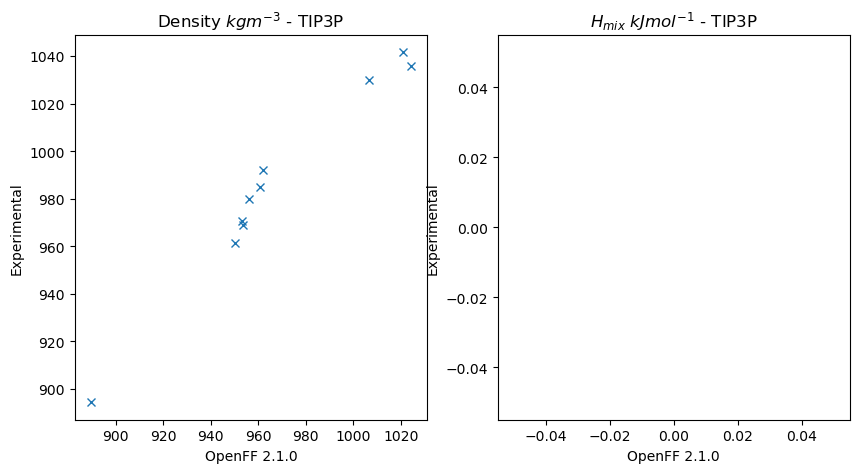

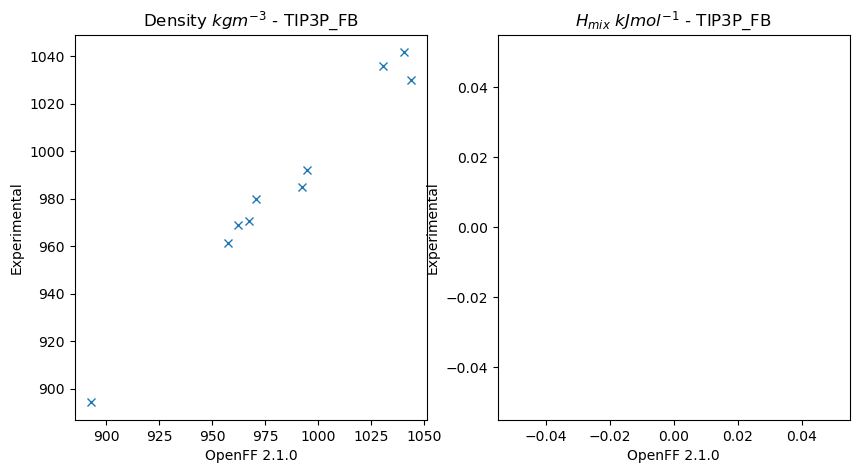

In [13]:
analysis_waters()

### Plotting results all together

In [14]:
testf=PhysicalPropertyDataSet.from_json('TIP3P/estimated_dataset_hmix_dens.json')

In [15]:
pandas_df=testf.to_pandas()

In [16]:
pandas_df.loc[pandas_df['Id'] == '6429']

,Id,Temperature (K),Pressure (kPa),Phase,N Components,Component 1,Role 1,Mole Fraction 1,Exact Amount 1,Component 2,Role 2,Mole Fraction 2,Exact Amount 2,Density Value (g / ml),Density Uncertainty (g / ml),EnthalpyOfMixing Value (kJ / mol),EnthalpyOfMixing Uncertainty (kJ / mol),Source
38,6429,298.15,101.0,Liquid,2,O,Solvent,0.699,None,OCCOCCO,Solvent,0.301,None,1.091015,0.000603,NaN,NaN,SimulationLayer


In [17]:
def analysis_all(phys_prop,water_model,functional_group):
    
    experimental_data_set_path = ('filtered_dataset_%s.json'%functional_group)
    estimated_data_set_path = ('%s/estimated_dataset_hmix_dens.json'%water_model)

    experimental_data_set = PhysicalPropertyDataSet.from_json(experimental_data_set_path)
    estimated_data_set = PhysicalPropertyDataSet.from_json(estimated_data_set_path)

    properties_by_type = {phys_prop: []}

    preferred_units = {
        "Density": unit.kilogram / unit.meter**3,
        "EnthalpyOfMixing": unit.kilojoule / unit.mole,
    }

    for experimental_property in experimental_data_set:

        if (type(experimental_property).__qualname__) == phys_prop:
    #     # Find the estimated property which has the same id as the
    #     # experimental property.
            property_type = experimental_property.__class__.__name__
            estimated_property = next(
                x for x in estimated_data_set if x.id == experimental_property.id
            )
            # Add this pair of properties to the list of pairs
            properties_by_type[property_type].append((experimental_property, estimated_property))
    

    preferred_unit = preferred_units[property_type]
        
    experimental_values = []
    estimated_values = []
   
    
    for experimental_property, estimated_property in properties_by_type[property_type]:
        experimental_values.append(
            experimental_property.value.to(preferred_unit).magnitude
        )
        estimated_values.append(
            estimated_property.value.to(preferred_unit).magnitude
        )

    def results_stats(x,y):    
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r2_value=r_value**2
        
        xarr=np.array(x)
        yarr=np.array(y)
        mse= ((xarr - yarr) ** 2).mean()
        rmse=np.sqrt(mse)

        stats=dict()
        stats['slope']=slope
        stats['intercept']=intercept
        stats['r_value']=r_value
        stats['r2_value']=r2_value
        stats['p_value']=p_value
        stats['std_err']=std_err
        stats['rmse']=rmse
        return stats

    results=dict()
    results["%s:%s-Experimental_Values" %(water_model,phys_prop)]=experimental_values
    results["%s:%s-Estimated_Values" %(water_model,phys_prop)]=estimated_values
    results["%s:%s-Stats" %(water_model,phys_prop)]=results_stats(estimated_values,experimental_values)
    
    return results

In [18]:
waters=('TIP3P','TIP3P_FB','TIP4P','TIP4P_FB','OPC','OPC3')

results_all=dict()
results_alcohols=dict()
results_amines=dict()
results_both=dict()
# results_other=dict()

for w in waters:
    dens_result_all=analysis_all('Density', w, 'all')
    results_all.update(dens_result_all)
    hmix_result_all=analysis_all('EnthalpyOfMixing',w,'all')
    results_all.update(hmix_result_all)
    
    dens_result_alcohols=analysis_all('Density', w, 'alcohols')
    results_alcohols.update(dens_result_alcohols)
    hmix_result_alcohols=analysis_all('EnthalpyOfMixing',w,'alcohols')
    results_alcohols.update(hmix_result_alcohols)

    dens_result_amines=analysis_all('Density', w, 'amines')
    results_amines.update(dens_result_amines)
    hmix_result_amines=analysis_all('EnthalpyOfMixing',w,'amines')
    results_amines.update(hmix_result_amines)

    dens_result_both=analysis_all('Density', w, 'both')
    results_both.update(dens_result_both)
    hmix_result_both=analysis_all('EnthalpyOfMixing',w,'both')
    results_both.update(hmix_result_both)

    # dens_result_other=analysis_all('Density', w, 'other')
    # results_other.update(dens_result_other)
    # hmix_result_other=analysis_all('EnthalpyOfMixing',w,'other')
    # results_other.update(hmix_result_other)




In [30]:
def plot_results(results, func):
    plt.figure(figsize=(12.0, 5.0))

    plt.subplot(1,2,1)
    plt.plot(results['TIP3P:EnthalpyOfMixing-Estimated_Values'], results['TIP3P:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
    plt.axline(xy1=(0,results['TIP3P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP3P:EnthalpyOfMixing-Stats']['rmse']))
    plt.plot(results['TIP3P_FB:EnthalpyOfMixing-Estimated_Values'], results['TIP3P_FB:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
    plt.axline(xy1=(0,results['TIP3P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP3P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:EnthalpyOfMixing-Stats']['r2_value'], results['TIP3P_FB:EnthalpyOfMixing-Stats']['rmse']))
    plt.plot(results['TIP4P:EnthalpyOfMixing-Estimated_Values'], results['TIP4P:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='g', label='TIP4P')
    plt.axline(xy1=(0,results['TIP4P:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P:EnthalpyOfMixing-Stats']['rmse']))
    plt.plot(results['TIP4P_FB:EnthalpyOfMixing-Estimated_Values'], results['TIP4P_FB:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='c',label='TIP4P_FB')
    plt.axline(xy1=(0,results['TIP4P_FB:EnthalpyOfMixing-Stats']['intercept']),slope=results['TIP4P_FB:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:EnthalpyOfMixing-Stats']['r2_value'],results['TIP4P_FB:EnthalpyOfMixing-Stats']['rmse']))
    plt.plot(results['OPC:EnthalpyOfMixing-Estimated_Values'], results['OPC:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='m', label='OPC')
    plt.axline(xy1=(0,results['OPC:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:EnthalpyOfMixing-Stats']['r2_value'],results['OPC:EnthalpyOfMixing-Stats']['rmse']))
    plt.plot(results['OPC3:EnthalpyOfMixing-Estimated_Values'], results['OPC3:EnthalpyOfMixing-Experimental_Values'], marker='x', linestyle='None', color='darkorange', label='OPC3')
    plt.axline(xy1=(0,results['OPC3:EnthalpyOfMixing-Stats']['intercept']),slope=results['OPC3:EnthalpyOfMixing-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:EnthalpyOfMixing-Stats']['r2_value'],results['OPC3:EnthalpyOfMixing-Stats']['rmse']))
    plt.title('$H_{mix}$ $kJ mol^{-1}$ - %s'%func)
    plt.xlabel('OpenFF 2.1.0')
    plt.ylabel('Experimental')
    plt.legend(prop={'size': 6})

    plt.subplot(1,2,2)
    plt.plot(results['TIP3P:Density-Estimated_Values'], results['TIP3P:Density-Experimental_Values'], marker='x', linestyle='None', color='r', label='TIP3P')
    plt.axline(xy1=(0,results['TIP3P:Density-Stats']['intercept']),slope=results['TIP3P:Density-Stats']['slope'], linestyle="--", color='r', alpha=0.5, label='TIP3P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P:Density-Stats']['r2_value'], results['TIP3P:Density-Stats']['rmse']))
    plt.plot(results['TIP3P_FB:Density-Estimated_Values'], results['TIP3P_FB:Density-Experimental_Values'], marker='x', linestyle='None', color='b',label='TIP3P_FB')
    plt.axline(xy1=(0,results['TIP3P_FB:Density-Stats']['intercept']),slope=results['TIP3P_FB:Density-Stats']['slope'], linestyle="--", color='b', alpha=0.5, label='TIP3P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP3P_FB:Density-Stats']['r2_value'], results['TIP3P_FB:Density-Stats']['rmse']))
    plt.plot(results['TIP4P:Density-Estimated_Values'], results['TIP4P:Density-Experimental_Values'], marker='x', linestyle='None', color='g', label='TIP4P')
    plt.axline(xy1=(0,results['TIP4P:Density-Stats']['intercept']),slope=results['TIP4P:Density-Stats']['slope'], linestyle="--", color='g', alpha=0.5, label='TIP4P $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P:Density-Stats']['r2_value'], results['TIP4P:Density-Stats']['rmse']))
    plt.plot(results['TIP4P_FB:Density-Estimated_Values'], results['TIP4P_FB:Density-Experimental_Values'], marker='x', linestyle='None', color='c',label='TIP4P_FB')
    plt.axline(xy1=(0,results['TIP4P_FB:Density-Stats']['intercept']),slope=results['TIP4P_FB:Density-Stats']['slope'], linestyle="--", color='c', alpha=0.5, label='TIP4P_FB $r^{2}$=%.3f, RMSE=%.3f'%(results['TIP4P_FB:Density-Stats']['r2_value'], results['TIP4P_FB:Density-Stats']['rmse']))
    plt.plot(results['OPC:Density-Estimated_Values'], results['OPC:Density-Experimental_Values'], marker='x', linestyle='None', color='m',label='OPC')
    plt.axline(xy1=(0,results['OPC:Density-Stats']['intercept']),slope=results['OPC:Density-Stats']['slope'], linestyle="--", color='m', alpha=0.5, label='OPC $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC:Density-Stats']['r2_value'], results['OPC:Density-Stats']['rmse']))
    plt.plot(results['OPC3:Density-Estimated_Values'], results['OPC3:Density-Experimental_Values'], marker='x', linestyle='None', color='darkorange',label='OPC3')
    plt.axline(xy1=(0,results['OPC3:Density-Stats']['intercept']),slope=results['OPC3:Density-Stats']['slope'], linestyle="--", color='darkorange', alpha=0.5, label='OPC3 $r^{2}$=%.3f, RMSE=%.3f'%(results['OPC3:Density-Stats']['r2_value'], results['OPC3:Density-Stats']['rmse']))
    plt.xlim(800,1200)
    plt.ylim(800,1200)
    plt.title('Density $kg m^{-3}$- %s'%func)
    plt.xlabel('OpenFF 2.1.0')
    plt.ylabel('Experimental')
    plt.legend(prop={'size': 6})

    plt.savefig('hmix_dens_plot_%s.png'%func)

    plt.show()

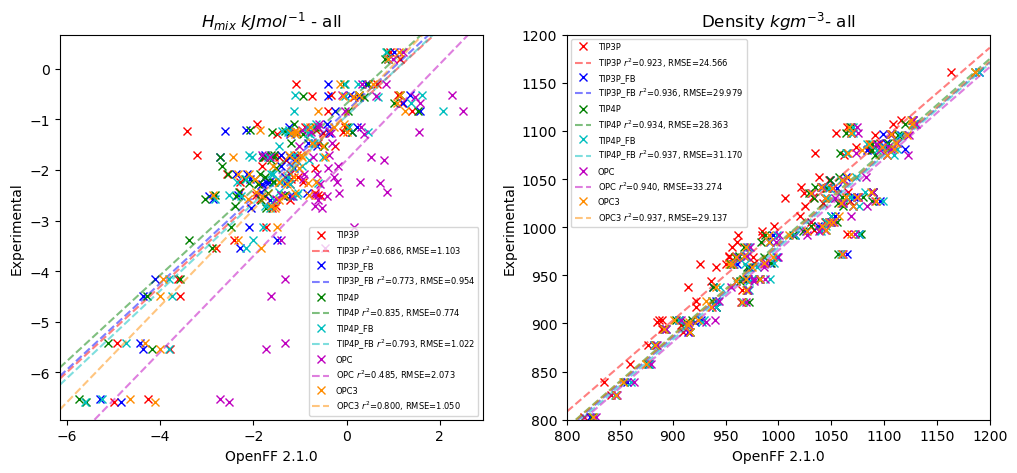

In [31]:
plot_results(results_all,'all')

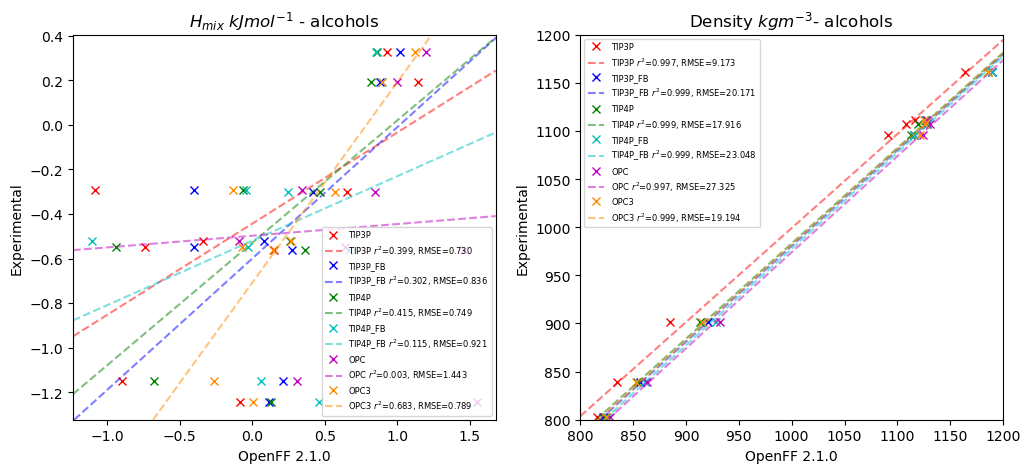

In [32]:
plot_results(results_alcohols,'alcohols')

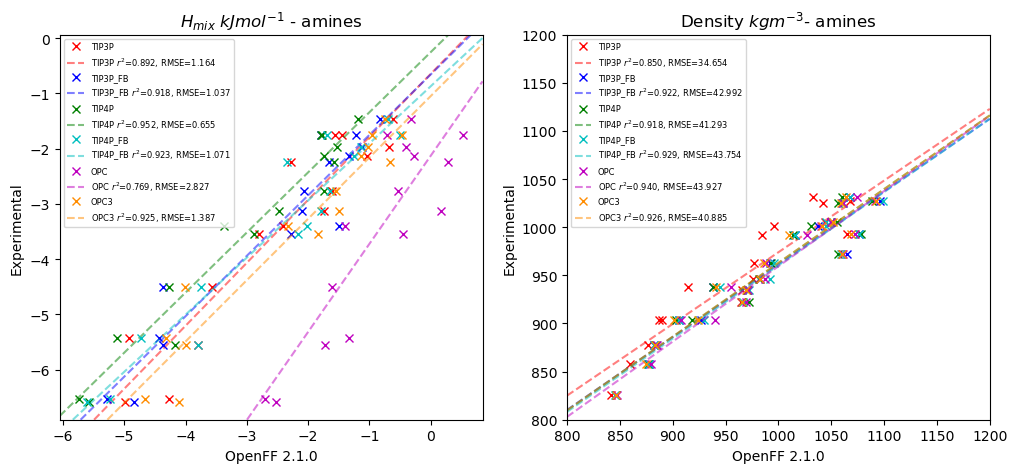

In [33]:
plot_results(results_amines,'amines')

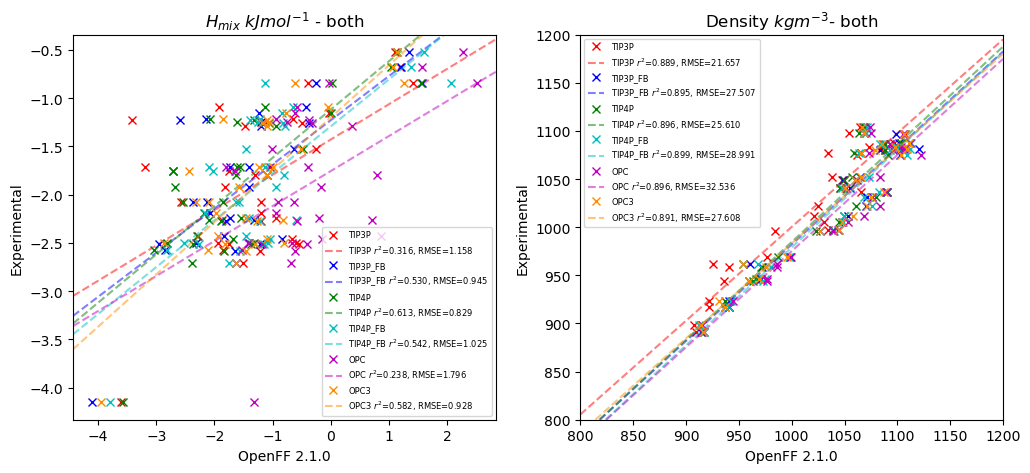

In [34]:
plot_results(results_both,'both')

## Info functional groups

In [24]:
filters = FilterCatalog.GetFlattenedFunctionalGroupHierarchy()
for k, pat in filters.items():
    print(f"{k} -> {Chem.MolToSmarts(pat)}")

AcidChloride -> C(=O)Cl
AcidChloride.Aliphatic -> [$(C-&!@[A&!Cl])](=O)Cl
AcidChloride.Aromatic -> [$(C-&!@a)](=O)Cl
Alcohol -> [O&H1&$(O-&!@[#6&!$(C=&!@[O,N,S])])]
Alcohol.Aliphatic -> [O&H1&$(O-&!@[C&!$(C=&!@[O,N,S])])]
Alcohol.Aromatic -> [O&H1&$(O-&!@c)]
Aldehyde -> [C&H1&D2&!$(C-[!#6&!#1])]=O
Aldehyde.Aliphatic -> [C&H1&D2&$(C-&!@C)]=O
Aldehyde.Aromatic -> [C&H1&D2&$(C-&!@a)]=O
Amine -> [N&$(N-[#6])&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Aliphatic -> [N&!$(N-c)&$(N-C)&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Aromatic -> [N&$(N-c)&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Cyclic -> [N&R&$(N-[#6])&!$(N-[!#6&!#1])&!$(N-C=[O,N,S])]
Amine.Primary -> [N&H2&D1&$(N-&!@[#6])&!$(N-C=[O,N,S])]
Amine.Primary.Aliphatic -> [N&H2&D1&$(N-&!@C)&!$(N-C=[O,N,S])]
Amine.Primary.Aromatic -> [N&H2&D1&$(N-&!@c)&!$(N-C=[O,N,S])]
Amine.Secondary -> [N&H1&D2&$(N(-[#6])-[#6])&!$(N-C=[O,N,S])]
Amine.Secondary.Aliphatic -> [N&H1&D2&$(N(-C)-C)&!$(N-C=[O,N,S])]
Amine.Secondary.Aromatic -> [N&H1&D2&$(N(-c)-[#6])&!$(N